In [20]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from ge.classify import read_node_label, Classifier
from ge import LINE
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import tensorflow as tf
from gensim import utils
from numpy import float32 as REAL
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
class GraphLoader:
    def __init__(self):
        self.graph = None
        self.title = None
        
    def build_graph(self, 
                    dataframe: pd.DataFrame, 
                    columns: List, 
                    edge_list: List,
                    verbose: bool = True,
                    title: str = 'Unnamed'):
        self.title = title
        t0 = time()
        self.graph = nx.Graph(name = self.title)

        # Add Nodes to the graph.
        for column in columns:
            self.graph.add_nodes_from(dataframe[column].values, label=column)

        # Add remaining columns as Node attributes. Optional
        remaining = dataframe.columns.difference(columns)
        for node, data in self.graph.nodes(data=True):
            if data["label"] == "K":
                self.graph.nodes[node]["K"] = dataframe.loc[dataframe["K"] == int(node), remaining].squeeze().to_dict()

        # Add Edges.
        for _, row in dataframe.loc[:, columns].iterrows():
            for edge in edge_list:
                self.graph.add_edge(row[edge[0]], row[edge[1]])
        
        if verbose:
            print(f"FINISHED in {np.round(time() - t0, 3)} seconds.")
            print(nx.info(self.graph))
        
        return self.graph

    def draw_graph(self, graph: nx.Graph, node_colors: dict, node: str = None, radius: int = 1) -> None:
        def assign_colors(graph: nx.Graph) -> List:
            # Assign Colors to nodes
            colors = []
            for n, data in graph.nodes(data=True):
                node = data["label"]
                colors.append(node_colors.get(node, "white"))
            return colors

        f = plt.figure(figsize = (20,12), facecolor="darkgray")
        ax = f.add_subplot()

        if not node:    
            plt.title(self.title)
        else:
            plt.title(f"Ego Graph around the node {node}, (radius={radius})")
            graph = nx.ego_graph(graph, node, radius = radius)
        
        colors = assign_colors(graph)
        nx.draw_networkx(graph, node_size = 300, node_color = colors, with_labels = False)
        # Add an empty plot to set custom legends
        from matplotlib.lines import Line2D
        ax.scatter([],[])
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='K', markerfacecolor = node_colors['K'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='S1', markerfacecolor = node_colors['S1'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S2', markerfacecolor = node_colors['S2'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S3', markerfacecolor = node_colors['S3'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S4', markerfacecolor = node_colors['S4'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S5', markerfacecolor = node_colors['S5'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S6', markerfacecolor = node_colors['S6'], markersize=10),

        ]
        ax.legend(handles=legend_elements, loc='best')
        plt.show()

In [22]:
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)
target_column = 'word'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']

df_attrition = df_attrition.loc[:, selected_columns]

In [23]:
attrition = 'test.csv'
df_ac = pd.read_csv(attrition,encoding='utf-8')

In [24]:
nodes = selected_columns[:] # Do not select Attrition as a feature node
edges = [("K","S1"),
         ("K","S2"),
         ("K","S3"),
         ("K","S4"),
         ("K","S5"),
         ("K","S6")]

node_colors = { # freestyle, update any color.
    "K": "dodgerblue", 
    "S1":"lightgreen", 
    "S2":"tan", 
    "S3":"salmon",
    "S4":"darkcyan",
    "S5":"lightblue",
    "S6":"yellow"
}

FINISHED in 0.089 seconds.
Graph named 'Multilingual Out of Vocabulary Terms relationship' with 502 nodes and 693 edges


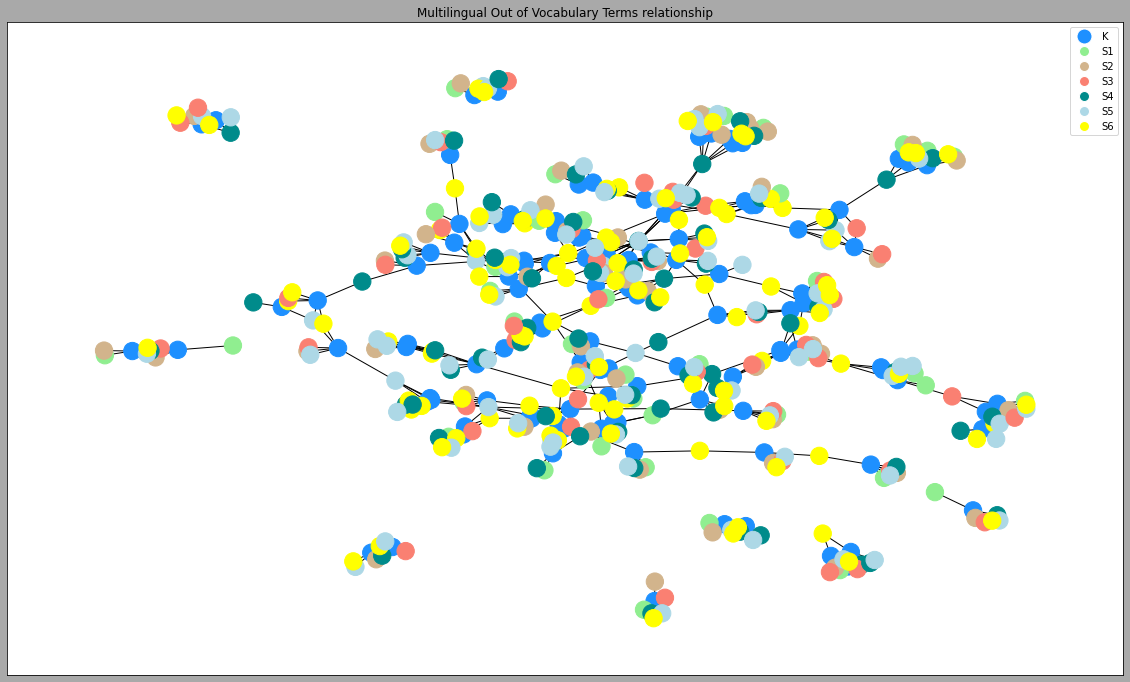

In [25]:
graph_loader = GraphLoader()
demo_graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:, selected_columns[:]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Multilingual Out of Vocabulary Terms relationship'
        )
# graph_loader.draw_graph(demo_graph, node_colors, node = 5, radius = 2) # show only the nodes that are at a distance of 2 edges from the employee 5.
graph_loader.draw_graph(demo_graph, node_colors) # Show the whole graph

In [26]:
len(demo_graph)

502

In [27]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(demo_graph.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [28]:
all_nodes = list(demo_graph.nodes())

random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,30))

100%|██████████| 502/502 [00:00<00:00, 21658.15it/s]


In [29]:
len(random_walks)

2510

In [30]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [31]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 12,vector_size=128)

model.build_vocab(random_walks, progress_per=2)

In [32]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(255953, 286000)

In [37]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
def save_model(model, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        d = 128
        w = 30
        n = 50
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}_deepwalk.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}_deepwalk.pkl"
        # Save only the embeddings in a txt file.
        model.wv.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        model.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")

In [38]:
save_model(model, save_to = EMBEDDINGS_DIR, prefix = "K")

Model and embeddings saved to: /home/gujiakai/Dropbox/毕业论文/实验/embeddings/K_model_128_30_50_deepwalk.pkl
